## The Trade-wind Cumulus Model

### Python packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import colormaps as cmaps
from matplotlib.gridspec import GridSpec

### Functions

In [2]:
# Latent heat of vaporization of water as a function of temperature [K]
def Lv(T):
    """
    Environmental Laboratory (1986). CE-QUAL-R1: A numerical one-dimensional model of rewervoir water quality. User's Manual,
    Instruction Report E-82-1 (Revised Edition), US Army Engineer Experiment Station, Vicksburg, Miss. pp.63-64.
    https://usace.contentdm.oclc.org/digital/collection/p266001coll1/id/6873/
    """
    Cpv = 1870   # Specific heat capacity of water vapor at constant pressure [J/kg/K] Bolton
    Cw  = 4190   # Specific heat capacity of liquid water at constant pressure [J/kg/K] Bolton
    T0  = 273.15 # Reference temperature [K]
    return 2.501e6 + (Cpv - Cw) * (T - T0) # [J/kg]

# Wexler/Buck 1981 formula (with enhancement factor at standard pressure)
def es_wexler(T_C, P=1013.25):  # P in hPa; T_C in Celsius
    """
    Buck, A. L. (1981). New Equations for Computing Vapor Pressure and Enhancement Factor. J. Appl. Meteorol., 20(12), 1527–1532.
    https://doi.org/10.1175/1520-0450(1981)020%3C1527:NEFCVP%3E2.0.CO;2
    """
    return 1e2 * 6.1121 * (1.0007 + 3.46e-6 * P) * np.exp((17.502 * T_C) / (240.97 + T_C))

# Saturation vapor pressure calculations
def q_sat(T_C, p=101325):  # p in Pa (default = 1013.25 hPa)
    Rv  = 461.5  # Gas constant for water vapor [J/kg/K]
    Rd  = 287.04 # Gas constant for dry air [J/kg/K]
    epsilon = Rd / Rv  # ratio of gas constants
    # es  = es_clausius_clapeyron(T_C)
    # es  = es_tetens(T_C)
    es  = es_wexler(T_C, p/100)
    return (epsilon * es) / (p - (1 - epsilon) * es)

def e_unsat(q, p=101325):
    Rv  = 461.5  # Gas constant for water vapor [J/kg/K]
    Rd  = 287.04 # Gas constant for dry air [J/kg/K]
    epsilon = Rd / Rv  # ratio of gas constants
    return (q * p) / (epsilon + q * (1 - epsilon))

def q_unsat(e, p=101325):
    Rv  = 461.5  # Gas constant for water vapor [J/kg/K]
    Rd  = 287.04 # Gas constant for dry air [J/kg/K]
    epsilon = Rd / Rv  # ratio of gas constants
    return (epsilon * e) / (p - e*(1-epsilon))

# Total water content calculation
def q_total(ae, dz, x, qs, qm, q_zcb, izcb):
    qtilde = (1 - x) * qm + x * qs

    qt = qtilde.copy()
    qt[0:izcb+1] = q_zcb  # set sub-cloud specific humidity
                          # Python is start inclusive, end exclusive, so must use izcb+1
                          # So qt[0:izcb+1] includes qt[izcb]
    for iz in range(izcb, len(qt)-1):
        if qt[iz] > qs[iz]:
            a1 = ae * dz
            Q1 = (qtilde[iz+1] + qtilde[iz]) / 2
            qt[iz+1] = ( (1-a1/2) * qt[iz] + a1*Q1 ) / (1 + a1/2)
        else:
            a2 = (1 - x) * ae * dz
            Q2 = (qm[iz+1] + qm[iz]) / 2
            qt[iz+1] = ( (1-a2/2) * qt[iz] + a2*Q2 ) / (1 + a2/2)
    return qt

# Cloud water flux calculation
# def cloudflux(ae, dz, x, ql, qm, qs, Ft, izcb, Ecb, rho_L):
#     Q = x * ae * ql / (qs - qm) * dz
def cloudflux(ae, dz, x, ql, qm, qt, Ft, izcb, Ecb, rho_L):
    Q = x * ae * ql / (qt - qm) * dz
    Fcld = Ft.copy()
    Fcld[:] = np.nan
    Fcld[izcb] = Ecb / rho_L
    for iz in range(izcb, len(Fcld)-1):
        Fcld[iz+1] = (Ft[iz+1] - Ft[iz] + Fcld[iz] * (1 - Q[iz]/2)) / (1 + Q[iz+1]/2)
    return Fcld

# def cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct):
#     Q = x * ae * ql / (qs - qm) * dz
def cloudflux_downward(ae, dz, x, ql, qm, qt, Ft, izcb, izct):
    Q = x * ae * ql / (qt - qm) * dz
    Fcld = Ft.copy()
    Fcld[:izct] = np.nan
    for iz in range(izct, izcb-1, -1):
        Fcld[iz] = (Ft[iz] - Ft[iz+1] + Fcld[iz+1] * (1 + Q[iz+1]/2)) / (1 - Q[iz]/2)
    return Fcld

### Data
We obtain environmental mean profiles of specific humidity, temperature, and pressure from the Ronald Brown ship sounding data while preciptiation rate, surface air density and temperature are from the surface measurements (Quinn et al., 2021; https://doi.org/10.5194/essd-13-1759-2021).
- https://www.ncei.noaa.gov/archive/accession/ATOMIC-2020
- The Atlantic Tradewind Ocean-Atmosphere Mesoscale Interaction Campaign (ATOMIC) was a field campaign held January-February 2020 in the tropical North Atlantic east of Barbados. The campaign, the U.S. complement to the European field campaign called EUREC4A, was aimed at better understanding cloud and air-sea interaction processes. ATOMIC included in measurements from a NOAA WP-3D Orion "Hurricane Hunter" aircraft, the research ship Ronald H. Brown, and unpiloted vehicles launched from Barbados and from the Ronald H. Brown.

In [3]:
# Ronald Brown data
rdir = "/Users/huang/Data/SimonsCAT/ATOMIC/RonBrown"
dsr  = xr.open_dataset(Path(rdir, "RonBrown_radiosondes.nc"))
dss  = xr.open_dataset(Path(rdir, "RonBrown_10min_flux.nc"))

### Variables

In [4]:
# Variables from Ronald Brown data
# Mean profiles over soundings
z    = dsr['alt'].values       # shape (alt,) [m]
tam  = dsr['ta'].mean(dim='sounding', skipna=True).values # mean air temperature [K]
qm   = dsr['q'].mean(dim='sounding', skipna=True).values # mean specific humidity [kg/kg]
pm   = dsr['p'].mean(dim='sounding', skipna=True).values # mean air pressure [Pa]

# Mean fluxes over 10-min intervals
lhf     = dss['hl_bulk'].values.squeeze()  # surface downward latent heat flux [W/m^2]
pr       = dss['prate'].values.squeeze()    # precipitation rate [mm/hr]
# ep      = dss['evap'].values.squeeze()    # evaporation rate [mm/hr]
rho_sfc  = dss['rhoair10'].values.squeeze()  # surface air density at 10-m [kg/m^3]
tair_sfc = dss['tair_ship'].values.squeeze()  # surface air temperature [degC]

In [5]:
# Constants
T0      = 273.15 # Reference temperature [K]
Rd      = 287.04 # Gas constant for dry air [J/kg/K]

zi      = 3000   # Inversion height [m]
ztop    = 4000   # Top of trade cumulus cloud layer [m]
zftop   = 8000   # Top of flux integration [m]
divg    = 1e-6   # Divergence of vertical velocity [s^-1]
# rho_sfc = 1.16   # Surface density [kg/m^3] obtained from surface data instead

In [6]:
# Variables derived from mean profiles
qs   = q_sat(tam - T0, pm)  # saturation specific humidity
dz   = (z[1] - z[0])        # vertical grid spacing in m
# dqdz = np.gradient(qm, dz)  # vertical gradient of specific humidity (central difference)
dqdz = np.diff(qm) / dz     #                                        (forward difference)

# Latent heat of vaporization avg LOWER than ztop
# Lv_m  = Lv(np.nanmean(tam[z <= ztop])) # [2.47e+6 J/kg]
# rho   = np.nanmean(pm[z <= ztop]) / (Rd * np.nanmean(tam[z <= ztop])) # mean air density avg lower than ztop [kg/m^3]
# rho_L = rho * Lv_m # Latent heat of vaporization times density avg lower than ztop [kg/m^3 J/kg]

# Latent heat of vaporization at SURFACE
Lvsfc_m  = Lv(np.nanmean(tair_sfc) + T0) # [2.44e+6 J/kg]
rhosfc_m = np.nanmean(rho_sfc) # mean surface air density [kg/m^3]
rhosfc_L = rhosfc_m * Lvsfc_m # Latent heat of vaporization times surface density [kg/m^3 J/kg]

### Prescribed large-scale terms

In [7]:
# Calculations: large-scale advections (prescribed)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv = w_dqdz + u_dqdx

In [8]:
# Perturbed large-scale advections (5% reduction)
# w5_dqdz = -( -divg * np.minimum(z[:-1], zi) * 0.95 ) * dqdz

# ls5_adv = w5_dqdz + u_dqdx

### The MODEL
- $\alpha+\epsilon$ varys from 6 to 0.649884 $km^{-1}$ (0.649884 is where we can have the highest cloud-top)
- FCloud-base height ($z_{cb}$) is chosen to be 700-m with specific humidify ($q_{zcb}$) equals 0.0152 $kg/kg$
- Precipitation efficiency ($x$) is ASSUMED to be a constant here ($x=0.56$, which is constrained by cloud-top height distribution).

In [9]:
# Pre-defined constants
Ecb = 170  # Evaporation rate at cloud base [W/m^2]
zcb = 700  # Cloud base height [m]
x   = 0.55 # Precipitation efficiency
upward = False  # True: integrate upward from cloud base; False: integrate downward from cloud top

# Total moisture flux at cloud base
print(f"{np.nanmean(pr) / 3600 * rhosfc_L:.2f} Wm^{-2}")
print(f"{-np.nanmean(lhf) :.2f} Wm^{-2}")
Fcb = Ecb / rhosfc_L - np.nanmean(pr) / 3600 # [kg/kg m/s]
izcb = np.where(z >= zcb)[0][0]  # find index where height is greater than or equal to zcb
q_zcb = qs[izcb]  # specific humidity at cloud base height

# Total moisture flux profile initialization
if upward:
    # Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
    Ft = qm.copy()
    Ft[1:izcb] = np.nan
    ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
    Ft[izcb:] = Fcb + ls_adv_cumsum
    print(f"{Ft[izcb]*rhosfc_L:.2f} Wm^{-2}")
else:
    # Or instead, integrate total moisture flux from 8 km downward
    izftop = np.where(z >= zftop)[0][0]
    Ft = qm.copy()
    Ft[izftop:] = np.zeros_like(Ft[izftop:])
    Ft[1:izcb] = np.nan
    ls_adv_cumsum = -np.flip(np.cumsum(np.flip(ls_adv[izcb:izftop]) * dz))
    Ft[izcb:izftop] = ls_adv_cumsum
    print(f"{Ft[izcb]*rhosfc_L:.2f} Wm^{-2}")

# Total sinking rate (entrainment + autoconversion): ec + ac [1/km]
# 0.649884 is the minimum value that gives cloud-top below 4000 m (highest cloud-top height)
aeo = 1e-3 * np.array([6, 5, 4, 3, 2.5, 2, 1.5, 1, 0.649884])
ec = (1 - x) * aeo # entrainment coefficient
ac = x * aeo       # autoconversion coefficient

25.40 Wm^-2
180.58 Wm^-2
139.68 Wm^-2


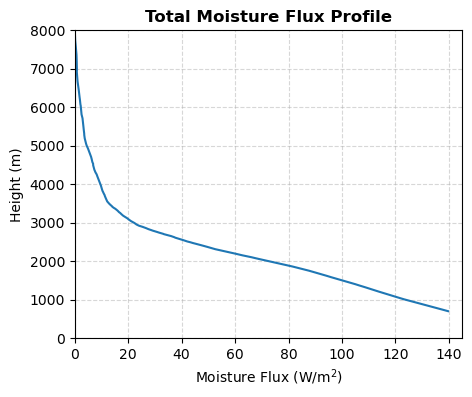

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))

plt.plot(Ft*rhosfc_L, z)

plt.xlim(0, 145)
plt.ylim(0, 8000)

plt.xlabel("Moisture Flux (W/m$^2$)")
plt.ylabel("Height (m)")
plt.title("Total Moisture Flux Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [11]:
# Run model for multiple combinations of α+ϵ
qt_out = []
ql_out = []
Fcld_out = []
Fpr_out = []
M_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
    ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
    Fcld = cloudflux_downward(ae, dz, x, ql, qm, qt, Ft, izcb, izct)
    Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # M = Fcld / (qs - qm)
    M = Fcld / (qt - qm)

    # Output results
    qt_out.append(qt)
    ql_out.append(ql)
    Fcld_out.append(Fcld)
    Fpr_out.append(Fpr)
    M_out.append(M)

Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 830.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 980.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1430.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1620.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1810.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 1990.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2270.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3100.00 m


### Plot

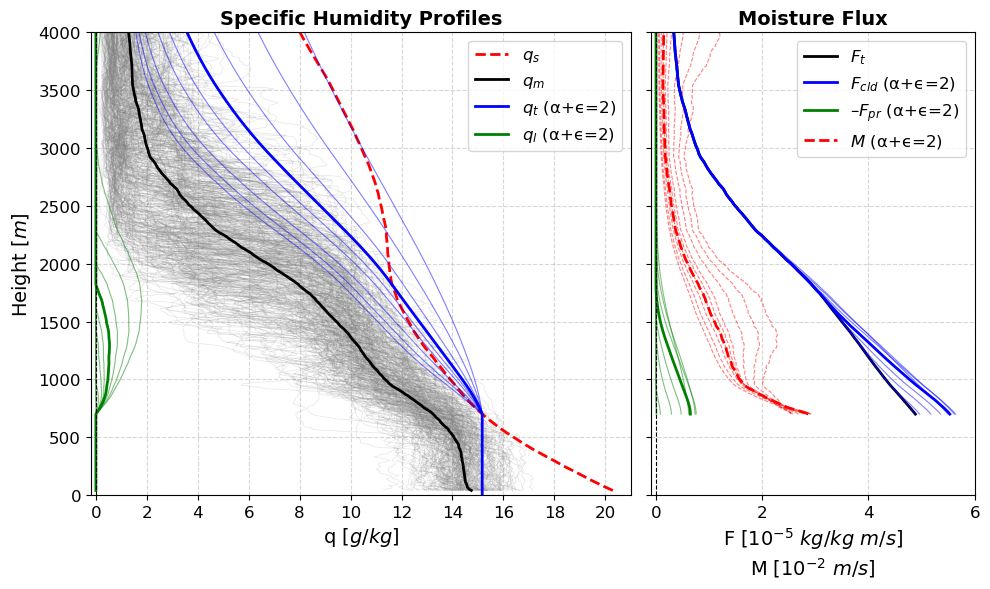

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [5, 3]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.5, alpha=0.2)
ax1.plot(qs*1000, z, color='r', linestyle='--', linewidth=2, label='$q_s$')
ax1.plot(qm*1000, z, color='k', linewidth=2, label='$q_m$')

ax2.plot(Ft*1e+5, z, color='k', linewidth=2, label='$F_t$')

for iae in range(len(aeo)):
    ax1.plot(qt_out[iae]*1000, z, color='b', linewidth=0.8, alpha=0.5)
    ax1.plot(ql_out[iae]*1000, z, color='g', linewidth=0.8, alpha=0.5)

    ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
    ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=0.8, alpha=0.5)
    ax2.plot(M_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=0.8, alpha=0.5)

    ax1.set_xlim(-0.2, 21)
    ax1.set_ylim(0, 4000)
    xticks = np.arange(0, 21, 2)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y', labelsize=12)
    ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
    ax1.set_ylabel(f'Height [$m$]', fontsize=14)
    ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
    ax1.grid(linestyle='--', alpha=0.5)

    ax2.set_xlim(-0.1, 6)
    ax2.set_ylim(0, 4000)
    ax2.tick_params(axis='x', labelsize=12)
    ax2.tick_params(axis='y', labelsize=12)
    ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
    ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
    ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
    ax2.grid(linestyle='--', alpha=0.5)

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
ax1.plot(qt_out[iae]*1000, z, color='b', linewidth=2, label='$q_t$ (α+ϵ=2)')
ax1.plot(ql_out[iae]*1000, z, color='g', linewidth=2, label='$q_l$ (α+ϵ=2)')
ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=2, label='$F_{cld}$ (α+ϵ=2)')
ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=2, label='$–F_{pr}$ (α+ϵ=2)')
ax2.plot(M_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=2, label='$M$ (α+ϵ=2)')

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')
ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

### Experiments: Increase Temperature by 1K

In [13]:
# IF TEMPERATURE INCREASE UNIFORMLY BY ? K
dtam = 1
tamdK = tam + dtam

# BUT RH ASSUMED TO REMAIN THE SAME
# Original:
em = e_unsat(qm, pm)  # mean vapor pressure
esm = es_wexler(tam - T0, pm / 100)  # saturation vapor pressure
rhm = em / esm

# New:
rhmdK = rhm
esmdK = es_wexler(tamdK - T0, pm / 100)
emdK = rhmdK * esmdK
qmdK = q_unsat(emdK, pm)
qsdK = q_sat(tamdK - T0, pm)

qdK_zcb = qsdK[izcb]

In [14]:
dqdzdK = np.diff(qmdK) / dz

# Calculations: large-scale advections (prescribed)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
wdK_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdzdK  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

lsdK_adv = wdK_dqdz + u_dqdx

# Total moisture flux profile initialization
if upward:
    # Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
    FtdK = qmdK.copy()
    FtdK[1:izcb] = np.nan
    lsdK_adv_cumsum = np.concatenate( ([0], np.cumsum(lsdK_adv[izcb:] * dz)) )
    FtdK[izcb:] = Fcb + lsdK_adv_cumsum
else:
    # Or instead, integrate total moisture flux from 8 km downward
    izftop = np.where(z >= zftop)[0][0]
    FtdK = qmdK.copy()
    FtdK[izftop:] = np.zeros_like(FtdK[izftop:])
    FtdK[1:izcb] = np.nan
    lsdK_adv_cumsum = -np.flip(np.cumsum(np.flip(lsdK_adv[izcb:izftop]) * dz))
    FtdK[izcb:izftop] = lsdK_adv_cumsum

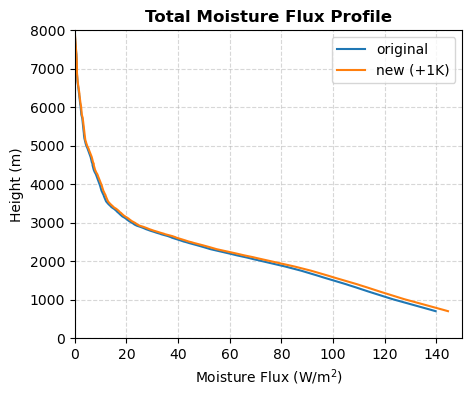

In [15]:
plt.figure(figsize=(5, 4))

plt.plot(Ft*rhosfc_L, z, label='original')
plt.plot(FtdK*rhosfc_L, z, label='new (+1K)')

plt.xlim(0, 150)
plt.ylim(0, 8000)

plt.xlabel("Moisture Flux (W/m$^2$)")
plt.ylabel("Height (m)")
plt.title("Total Moisture Flux Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [16]:
# IF TEMPERATURE INCREASE UNIFORMLY BY 1 K
# Run model for multiple combinations of α+ϵ
qtdK_out = []
qldK_out = []
FclddK_out = []
FprdK_out = []
MdK_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qsdK, qmdK, qdK_zcb, izcb)
    ql = np.maximum(qt - qsdK, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, Ft, izcb, izct)
    # Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top
    Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, FtdK, izcb, izct)
    Fpr = Fcld - FtdK # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # M = Fcld / (qs - qm)
    M = Fcld / (qt - qmdK)
    
    # Output results
    qtdK_out.append(qt)
    qldK_out.append(ql)
    FclddK_out.append(Fcld)
    FprdK_out.append(Fpr)
    MdK_out.append(M)

Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 830.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 970.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1420.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1610.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1800.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 1990.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2260.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3000.00 m


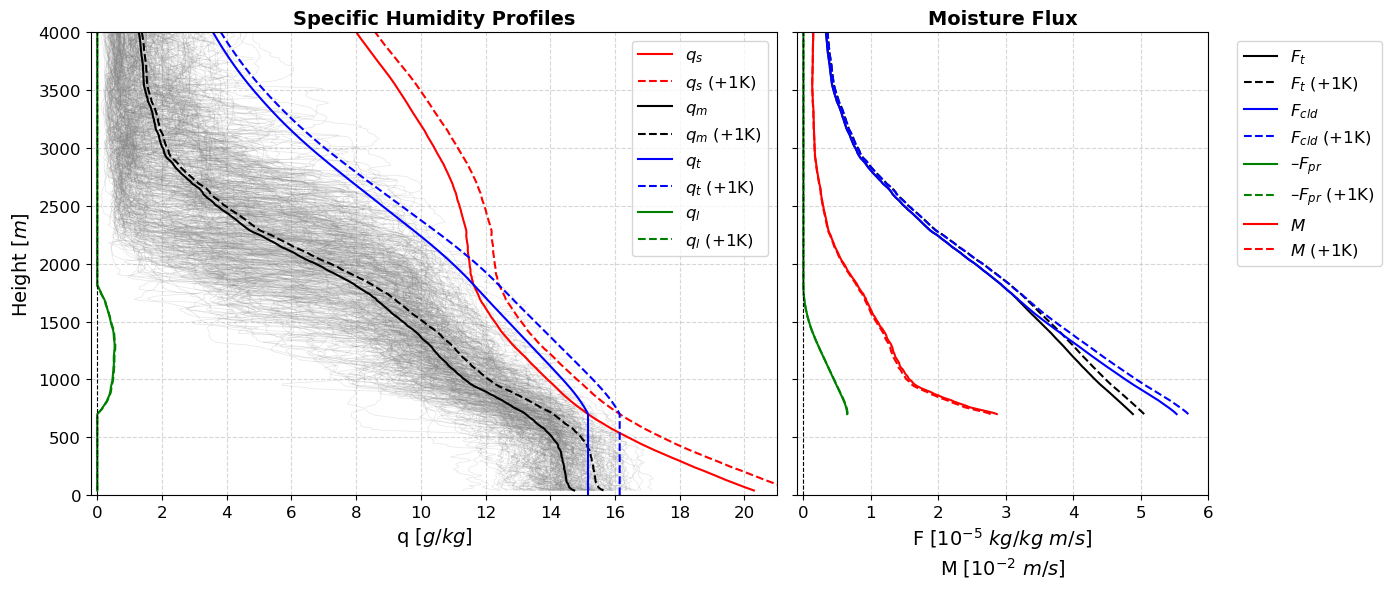

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [5, 3]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.5, alpha=0.2)
ax1.plot(qs*1000, z, color='r', linewidth=1.5, label='$q_s$')
ax1.plot(qsdK*1000, z, color='r', linestyle='--', linewidth=1.5, label='$q_s$ (+1K)')

ax1.plot(qm*1000, z, color='k', linewidth=1.5, label='$q_m$')
ax1.plot(qmdK*1000, z, color='k', linestyle='--', linewidth=1.5, label='$q_m$ (+1K)')

ax2.plot(Ft*1e+5, z, color='k', linewidth=1.5, label='$F_t$')
ax2.plot(FtdK*1e+5, z, color='k', linestyle='--', linewidth=1.5, label='$F_t$ (+1K)')

# for iae in range(len(aeo)):
#     ax1.plot(qtdK_out[iae]*1000, z, color='b', linewidth=0.8, alpha=0.5)
#     ax1.plot(qldK_out[iae]*1000, z, color='g', linewidth=0.8, alpha=0.5)

#     ax2.plot(FclddK_out[iae]*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
#     ax2.plot(FprdK_out[iae]*1e+5, z, color='g', linewidth=0.8, alpha=0.5)
#     ax2.plot(MdK_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=0.8, alpha=0.5)

#     ax1.set_xlim(-0.2, 21)
#     ax1.set_ylim(0, 4000)
#     xticks = np.arange(0, 21, 2)
#     ax1.set_xticks(xticks)
#     ax1.set_xticklabels(xticks)
#     ax1.tick_params(axis='x', labelsize=12)
#     ax1.tick_params(axis='y', labelsize=12)
#     ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
#     ax1.set_ylabel(f'Height [$m$]', fontsize=14)
#     ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
#     ax1.grid(linestyle='--', alpha=0.5)

#     ax2.set_xlim(-0.1, 6)
#     ax2.set_ylim(0, 4000)
#     ax2.tick_params(axis='x', labelsize=12)
#     ax2.tick_params(axis='y', labelsize=12)
#     ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
#     ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
#     ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
#     ax2.grid(linestyle='--', alpha=0.5)

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
ax1.plot(qt_out[iae]*1000, z, color='b', linewidth=1.5, label='$q_t$')
ax1.plot(qtdK_out[iae]*1000, z, color='b', linestyle='--', linewidth=1.5, label='$q_t$ (+1K)')

ax1.plot(ql_out[iae]*1000, z, color='g', linewidth=1.5, label='$q_l$')
ax1.plot(qldK_out[iae]*1000, z, color='g', linestyle='--', linewidth=1.5, label='$q_l$ (+1K)')

ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=1.5, label='$F_{cld}$')
ax2.plot(FclddK_out[iae]*1e+5, z, color='b', linestyle='--', linewidth=1.5, label='$F_{cld}$ (+1K)')

ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=1.5, label='$–F_{pr}$')
ax2.plot(FprdK_out[iae]*1e+5, z, color='g', linestyle='--', linewidth=1.5, label='$–F_{pr}$ (+1K)')

ax2.plot(M_out[iae]*1e+2, z, color='r', linewidth=1.5, label='$M$')
ax2.plot(MdK_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=1.5, label='$M$ (+1K)')

ax1.set_xlim(-0.2, 21)
ax1.set_ylim(0, 4000)
xticks = np.arange(0, 21, 2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
ax1.set_ylabel(f'Height [$m$]', fontsize=14)
ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
ax1.grid(linestyle='--', alpha=0.5)

ax2.set_xlim(-0.1, 6)
ax2.set_ylim(0, 4000)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
ax2.grid(linestyle='--', alpha=0.5)

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')
# ax2.legend(fontsize=12, loc='upper right')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()

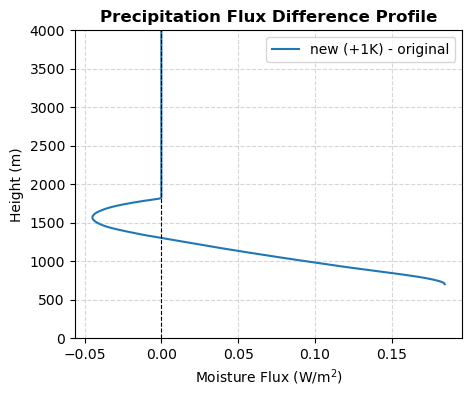

In [18]:
plt.figure(figsize=(5, 4))

plt.plot(FprdK_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (+1K) - original')

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

# plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.xlabel("Moisture Flux (W/m$^2$)")
plt.ylabel("Height (m)")
plt.title("Precipitation Flux Difference Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [19]:
Fpr_out[iae][izcb]*rhosfc_L, FprdK_out[iae][izcb]*rhosfc_L, (FprdK_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]

(18.53863714787141, 18.723118956003017, 0.009951207)

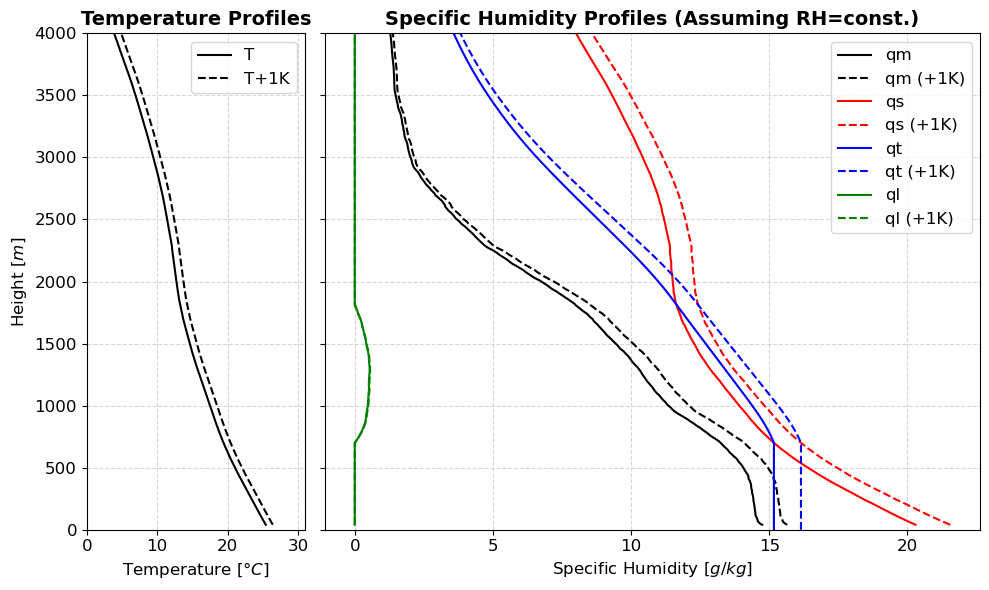

In [20]:
plt.figure(figsize=(10, 6))
gs  = GridSpec(1, 2, width_ratios=[1, 3])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# 1
plt.sca(ax1)
plt.plot(tam-T0, z, color='k', label='T')
plt.plot(tamdK-T0, z, color='k', linestyle='--', label=f'T+{dtam}K')

plt.xlim(0, 31)
plt.ylim(0, 4000)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel(f'Temperature [$\degree C$]', fontsize=12)
plt.ylabel(f'Height [$m$]', fontsize=12)
plt.title(f'Temperature Profiles', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

plt.grid(linestyle='--', alpha=0.5)

# 2
plt.sca(ax2)
plt.plot(qm*1000, z, color='k', label='qm')
plt.plot(qmdK*1000, z, color='k', linestyle='--', label=f'qm (+{dtam}K)')
plt.plot(qs*1000, z, color='red', label='qs')
plt.plot(qsdK*1000, z, color='red', linestyle='--', label=f'qs (+{dtam}K)')

iae = 5
plt.plot(qt_out[iae]*1000, z, color='b', label='qt')
plt.plot(qtdK_out[iae]*1000, z, color='b', linestyle='--', label=f'qt (+{dtam}K)')
plt.plot(ql_out[iae]*1000, z, color='g', label='ql')
plt.plot(qldK_out[iae]*1000, z, color='g', linestyle='--', label=f'ql (+{dtam}K)')

plt.ylim(0, 4000)
plt.tick_params(axis='y', labelleft=False)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel(f'Specific Humidity [$g/kg$]', fontsize=12)
plt.title(f'Specific Humidity Profiles (Assuming RH=const.)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)

plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Experiment: LS decreases by 5%

In [21]:
# dqdzdK = np.diff(qmdK) / dz

# Calculations: large-scale advections (prescribed)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv5 = (w_dqdz + u_dqdx) * 0.95

# Total moisture flux profile initialization
if upward:
    # Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
    Ft5 = qm.copy()
    Ft5[1:izcb] = np.nan
    ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv5[izcb:] * dz)) )
    Ft5[izcb:] = Fcb + ls_adv_cumsum
else:
    # Or instead, integrate total moisture flux from 8 km downward
    izftop = np.where(z >= zftop)[0][0]
    Ft5 = qm.copy()
    Ft5[izftop:] = np.zeros_like(Ft5[izftop:])
    Ft5[1:izcb] = np.nan
    ls_adv_cumsum = -np.flip(np.cumsum(np.flip(ls_adv5[izcb:izftop]) * dz))
    Ft5[izcb:izftop] = ls_adv_cumsum

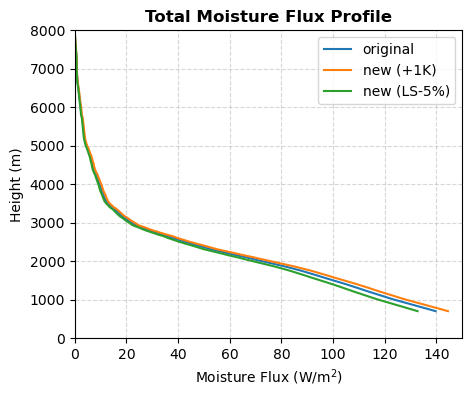

In [22]:
plt.figure(figsize=(5, 4))

plt.plot(Ft*rhosfc_L, z, label='original')
plt.plot(FtdK*rhosfc_L, z, label='new (+1K)')
plt.plot(Ft5*rhosfc_L, z, label='new (LS-5%)')

plt.xlim(0, 150)
plt.ylim(0, 8000)

plt.xlabel("Moisture Flux (W/m$^2$)")
plt.ylabel("Height (m)")
plt.title("Total Moisture Flux Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [23]:
# IF LS reduce by 5%
# Run model for multiple combinations of α+ϵ
Fcld5_out = []
Fpr5_out = []
M5_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
    ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, Ft, izcb, izct)
    # Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top
    Fcld = cloudflux_downward(ae, dz, x, ql, qm, qt, Ft5, izcb, izct)
    Fpr = Fcld - Ft5 # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # M = Fcld / (qs - qm)
    M = Fcld / (qt - qm)
    
    # Output results
    Fcld5_out.append(Fcld)
    Fpr5_out.append(Fpr)
    M5_out.append(M)

Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 830.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 980.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1430.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1620.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1810.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 1990.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2270.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3100.00 m


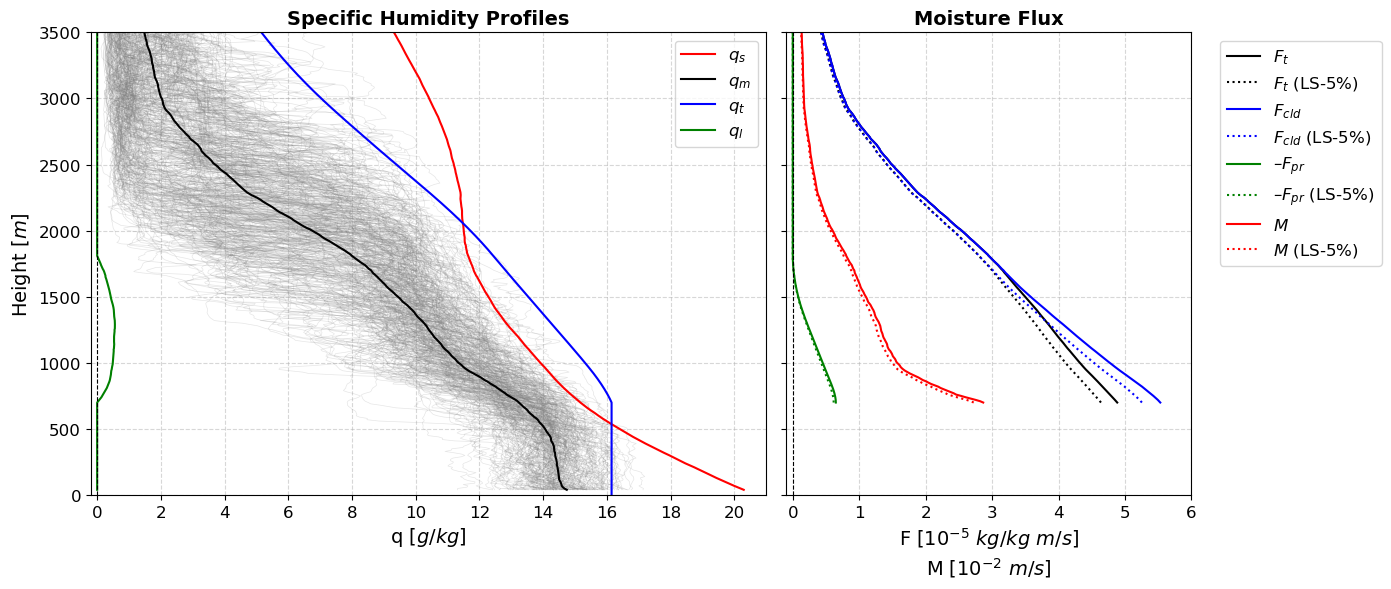

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [5, 3]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.5, alpha=0.2)
ax1.plot(qs*1000, z, color='r', linewidth=1.5, label='$q_s$')
# ax1.plot(qsdK*1000, z, color='r', linestyle='--', linewidth=1.5, label='$q_s$ (+1K)')

ax1.plot(qm*1000, z, color='k', linewidth=1.5, label='$q_m$')
# ax1.plot(qmdK*1000, z, color='k', linestyle='--', linewidth=1.5, label='$q_m$ (+1K)')

ax2.plot(Ft*1e+5, z, color='k', linewidth=1.5, label='$F_t$')
# ax2.plot(FtdK*1e+5, z, color='k', linestyle='--', linewidth=1.5, label='$F_t$ (+1K)')
ax2.plot(Ft5*1e+5, z, color='k', linestyle=':', linewidth=1.5, label='$F_t$ (LS-5%)')

# for iae in range(len(aeo)):
#     ax1.plot(qtdK_out[iae]*1000, z, color='b', linewidth=0.8, alpha=0.5)
#     ax1.plot(qldK_out[iae]*1000, z, color='g', linewidth=0.8, alpha=0.5)

#     ax2.plot(FclddK_out[iae]*1e+5, z, color='b', linewidth=0.8, alpha=0.5)
#     ax2.plot(FprdK_out[iae]*1e+5, z, color='g', linewidth=0.8, alpha=0.5)
#     ax2.plot(MdK_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=0.8, alpha=0.5)

#     ax1.set_xlim(-0.2, 21)
#     ax1.set_ylim(0, 4000)
#     xticks = np.arange(0, 21, 2)
#     ax1.set_xticks(xticks)
#     ax1.set_xticklabels(xticks)
#     ax1.tick_params(axis='x', labelsize=12)
#     ax1.tick_params(axis='y', labelsize=12)
#     ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
#     ax1.set_ylabel(f'Height [$m$]', fontsize=14)
#     ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
#     ax1.grid(linestyle='--', alpha=0.5)

#     ax2.set_xlim(-0.1, 6)
#     ax2.set_ylim(0, 4000)
#     ax2.tick_params(axis='x', labelsize=12)
#     ax2.tick_params(axis='y', labelsize=12)
#     ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
#     ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
#     ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
#     ax2.grid(linestyle='--', alpha=0.5)

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
ax1.plot(qtdK_out[iae]*1000, z, color='b', linewidth=1.5, label='$q_t$')
# ax1.plot(qt_out[iae]*1000, z, color='b', linestyle='--', linewidth=1.5, label='$q_t$ (+1K)')

ax1.plot(qldK_out[iae]*1000, z, color='g', linewidth=1.5, label='$q_l$')
# ax1.plot(ql_out[iae]*1000, z, color='g', linestyle='--', linewidth=1.5, label='$q_l$ (+1K)')

ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=1.5, label='$F_{cld}$')
# ax2.plot(FclddK_out[iae]*1e+5, z, color='b', linestyle='--', linewidth=1.5, label='$F_{cld}$ (+1K)')
ax2.plot(Fcld5_out[iae]*1e+5, z, color='b', linestyle=':', linewidth=1.5, label='$F_{cld}$ (LS-5%)')

ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=1.5, label='$–F_{pr}$')
# ax2.plot(FprdK_out[iae]*1e+5, z, color='g', linestyle='--', linewidth=1.5, label='$–F_{pr}$ (+1K)')
ax2.plot(Fpr5_out[iae]*1e+5, z, color='g', linestyle=':', linewidth=1.5, label='$–F_{pr}$ (LS-5%)')

ax2.plot(M_out[iae]*1e+2, z, color='r', linewidth=1.5, label='$M$')
# ax2.plot(MdK_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=1.5, label='$M$ (+1K)')
ax2.plot(M5_out[iae]*1e+2, z, linestyle=':', color='r', linewidth=1.5, label='$M$ (LS-5%)')

ax1.set_xlim(-0.2, 21)
ax1.set_ylim(0, 3500)
xticks = np.arange(0, 21, 2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
ax1.set_ylabel(f'Height [$m$]', fontsize=14)
ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
ax1.grid(linestyle='--', alpha=0.5)

ax2.set_xlim(-0.1, 6)
# ax2.set_xlim(2.5, 6)
ax2.set_ylim(0, 3500)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
ax2.grid(linestyle='--', alpha=0.5)

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')

# ax2 legend east outside of plot
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
# ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


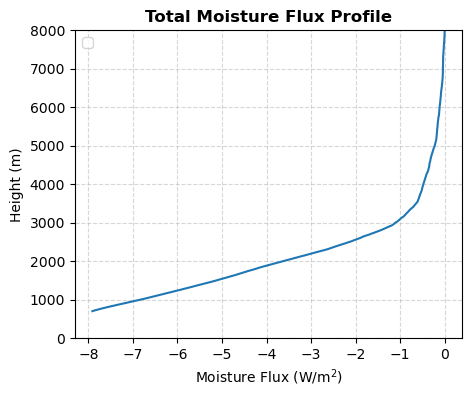

In [25]:
plt.figure(figsize=(5, 4))

plt.plot(Fcld5_out[iae]*rhosfc_L-Fcld_out[iae]*rhosfc_L, z)
# plt.plot(FclddK_out[iae]*rhosfc_L, z, label='new (+1K)')
# plt.plot(Fcld5_out[iae]*rhosfc_L, z, label='new (LS-5%)')

# plt.xlim(0, 150)
plt.ylim(0, 8000)

plt.xlabel("Moisture Flux (W/m$^2$)")
plt.ylabel("Height (m)")
plt.title("Total Moisture Flux Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

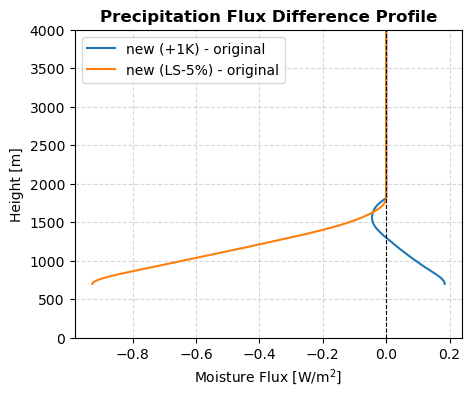

In [26]:
plt.figure(figsize=(5, 4))

plt.plot(FprdK_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (+1K) - original')
plt.plot(Fpr5_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (LS-5%) - original')

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

# plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.xlabel("Moisture Flux [W/m$^2$]")
plt.ylabel("Height [m]")
plt.title("Precipitation Flux Difference Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [27]:
print(Fpr_out[iae][izcb]*rhosfc_L, FprdK_out[iae][izcb]*rhosfc_L, Fpr5_out[iae][izcb]*rhosfc_L)
print(f"{(FprdK_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]:.2%}")
print(f"{(Fpr5_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]:.2%}")

18.53863714787141 18.723118956003017 17.6116600258907
1.00%
-5.00%


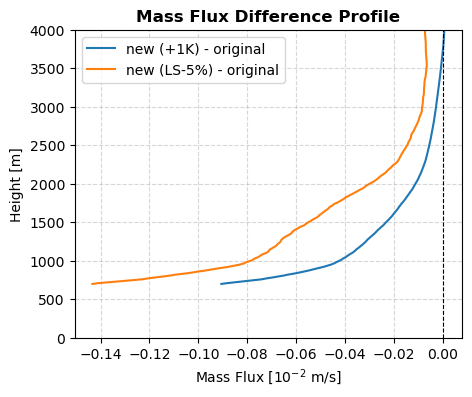

In [44]:
plt.figure(figsize=(5, 4))

plt.plot((MdK_out[iae]-M_out[iae])*1e2, z, label='new (+1K) - original')
plt.plot((M5_out[iae]-M_out[iae])*1e2, z, label='new (LS-5%) - original')

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

# plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.xlabel(f"Mass Flux [$10^{{-2}}$ m/s]")
plt.ylabel("Height [m]")
plt.title("Mass Flux Difference Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [29]:
print(M_out[iae][izcb], MdK_out[iae][izcb], M5_out[iae][izcb])
print(f"{(MdK_out[iae][izcb]-M_out[iae][izcb])/M_out[iae][izcb]:.2%}")
print(f"{(M5_out[iae][izcb]-M_out[iae][izcb])/M_out[iae][izcb]:.2%}")

0.028664788 0.027759071 0.02723154
-3.16%
-5.00%


### Experiment: Temp increases by 1 K and LS decreases by 5%

In [30]:
# Calculations: large-scale advections (prescribed)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
wdK_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdzdK  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

lsdK_adv5 = (wdK_dqdz + u_dqdx) * 0.95

# Total moisture flux profile initialization
if upward:
    # Integrate total moisture flux balancing subsidence drying and horizontal advection from cloud base
    FtdK5 = qmdK.copy()
    FtdK5[1:izcb] = np.nan
    lsdK_adv_cumsum = np.concatenate( ([0], np.cumsum(lsdK_adv5[izcb:] * dz)) )
    FtdK5[izcb:] = Fcb + lsdK_adv_cumsum
else:
    # Or instead, integrate total moisture flux from 8 km downward
    izftop = np.where(z >= zftop)[0][0]
    FtdK5 = qmdK.copy()
    FtdK5[izftop:] = np.zeros_like(FtdK5[izftop:])
    FtdK5[1:izcb] = np.nan
    lsdK_adv_cumsum = -np.flip(np.cumsum(np.flip(lsdK_adv5[izcb:izftop]) * dz))
    FtdK5[izcb:izftop] = lsdK_adv_cumsum

In [31]:
# IF Temp increases by 1K and LS reduces by 5%
# Run model for multiple combinations of α+ϵ
FclddK5_out = []
FprdK5_out = []
MdK5_out = []
for ae in aeo:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qsdK, qmdK, qdK_zcb, izcb)
    ql = np.maximum(qt - qsdK, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
    # Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, Ft, izcb, izct)
    # Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top
    Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, FtdK5, izcb, izct)
    Fpr = Fcld - FtdK5 # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    # M = Fcld / (qs - qm)
    M = Fcld / (qt - qmdK)
    
    # Output results
    FclddK5_out.append(Fcld)
    FprdK5_out.append(Fpr)
    MdK5_out.append(M)

Case with α+ϵ= 6.000000 1/km, cloud top at 700.00 m
Case with α+ϵ= 5.000000 1/km, cloud top at 830.00 m
Case with α+ϵ= 4.000000 1/km, cloud top at 970.00 m
Case with α+ϵ= 3.000000 1/km, cloud top at 1420.00 m
Case with α+ϵ= 2.500000 1/km, cloud top at 1610.00 m
Case with α+ϵ= 2.000000 1/km, cloud top at 1800.00 m
Case with α+ϵ= 1.500000 1/km, cloud top at 1990.00 m
Case with α+ϵ= 1.000000 1/km, cloud top at 2260.00 m
Case with α+ϵ= 0.649884 1/km, cloud top at 3000.00 m


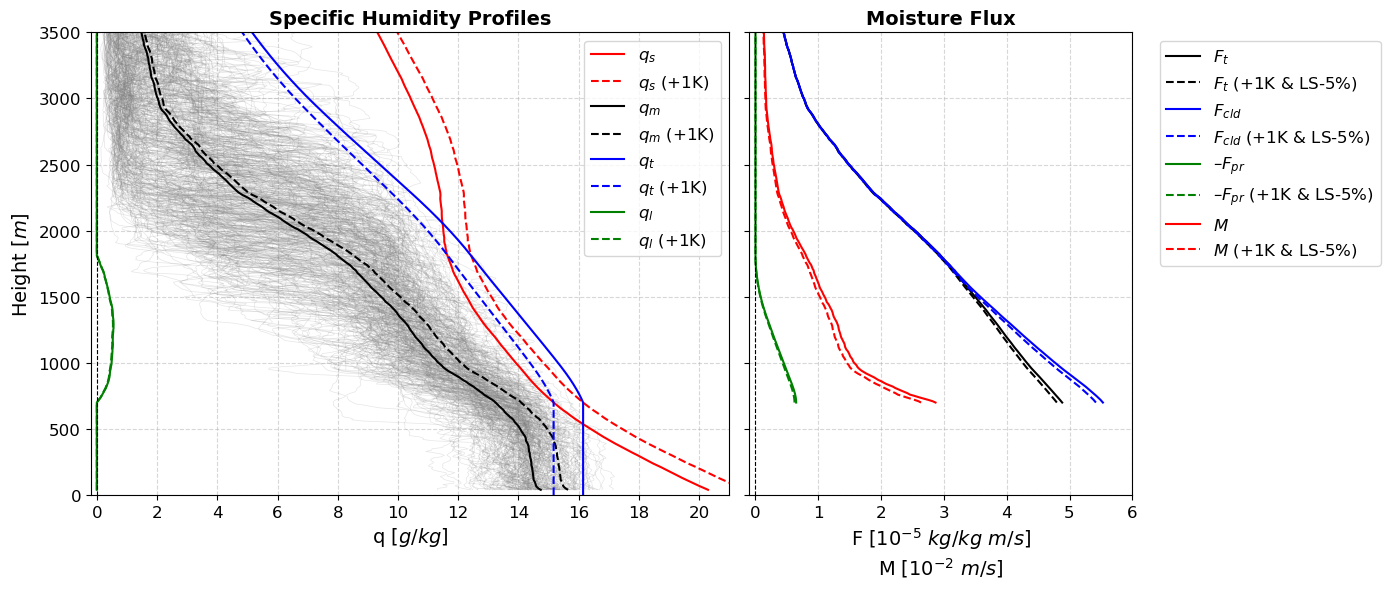

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [5, 3]})

# Observations from Ron Brown soundings
for i in range(dsr['sounding'].size):
    ax1.plot(dsr['q'].isel(sounding=i).values*1000, z, color='gray', linewidth=0.5, alpha=0.2)
ax1.plot(qs*1000, z, color='r', linewidth=1.5, label='$q_s$')
ax1.plot(qsdK*1000, z, color='r', linestyle='--', linewidth=1.5, label='$q_s$ (+1K)')

ax1.plot(qm*1000, z, color='k', linewidth=1.5, label='$q_m$')
ax1.plot(qmdK*1000, z, color='k', linestyle='--', linewidth=1.5, label='$q_m$ (+1K)')

ax2.plot(Ft*1e+5, z, color='k', linewidth=1.5, label='$F_t$')
ax2.plot(FtdK5*1e+5, z, color='k', linestyle='--', linewidth=1.5, label='$F_t$ (+1K & LS-5%)')

# Case with α+ϵ= 2 1/km
iae = np.where(aeo == 2e-3)[0][0]
ax1.plot(qtdK_out[iae]*1000, z, color='b', linewidth=1.5, label='$q_t$')
ax1.plot(qt_out[iae]*1000, z, color='b', linestyle='--', linewidth=1.5, label='$q_t$ (+1K)')

ax1.plot(qldK_out[iae]*1000, z, color='g', linewidth=1.5, label='$q_l$')
ax1.plot(ql_out[iae]*1000, z, color='g', linestyle='--', linewidth=1.5, label='$q_l$ (+1K)')

ax2.plot(Fcld_out[iae]*1e+5, z, color='b', linewidth=1.5, label='$F_{cld}$')
ax2.plot(FclddK5_out[iae]*1e+5, z, color='b', linestyle='--', linewidth=1.5, label='$F_{cld}$ (+1K & LS-5%)')

ax2.plot(Fpr_out[iae]*1e+5, z, color='g', linewidth=1.5, label='$–F_{pr}$')
ax2.plot(FprdK5_out[iae]*1e+5, z, color='g', linestyle='--', linewidth=1.5, label='$–F_{pr}$ (+1K & LS-5%)')

ax2.plot(M_out[iae]*1e+2, z, color='r', linewidth=1.5, label='$M$')
ax2.plot(MdK5_out[iae]*1e+2, z, linestyle='--', color='r', linewidth=1.5, label='$M$ (+1K & LS-5%)')

ax1.set_xlim(-0.2, 21)
ax1.set_ylim(0, 3500)
xticks = np.arange(0, 21, 2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_xlabel(f'q [$g/kg$]', fontsize=14)
ax1.set_ylabel(f'Height [$m$]', fontsize=14)
ax1.set_title('Specific Humidity Profiles', fontsize=14, fontweight='bold')
ax1.grid(linestyle='--', alpha=0.5)

ax2.set_xlim(-0.1, 6)
# ax2.set_xlim(2.5, 6)
ax2.set_ylim(0, 3500)
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel(r'F [$10^{-5}$ $kg/kg$ $m/s$]' '\n' 'M [$10^{-2}$ $m/s$]', fontsize=14)
ax2.set_yticklabels([])  # Hide y-axis labels on the right plot
ax2.set_title('Moisture Flux', fontsize=14, fontweight='bold')
ax2.grid(linestyle='--', alpha=0.5)

# Final touches
ax1.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.8)
ax1.legend(fontsize=12, loc='upper right')

# ax2 legend east outside of plot
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
# ax2.legend(fontsize=12, loc='upper right')

plt.tight_layout()
plt.show()

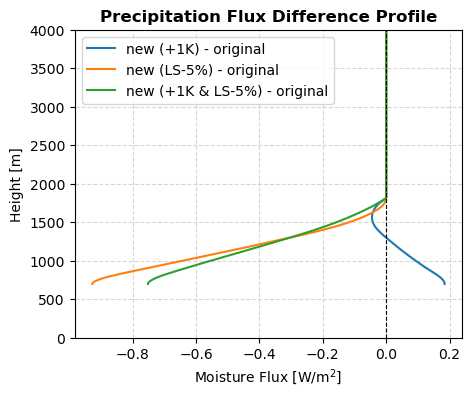

In [38]:
plt.figure(figsize=(5, 4))

plt.plot(FprdK_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (+1K) - original')
plt.plot(Fpr5_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (LS-5%) - original')
plt.plot(FprdK5_out[iae]*rhosfc_L-Fpr_out[iae]*rhosfc_L, z, label='new (+1K & LS-5%) - original')

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

# plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.xlabel("Moisture Flux [W/m$^2$]")
plt.ylabel("Height [m]")
plt.title("Precipitation Flux Difference Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [40]:
print(Fpr_out[iae][izcb]*rhosfc_L, FprdK_out[iae][izcb]*rhosfc_L, Fpr5_out[iae][izcb]*rhosfc_L, FprdK5_out[iae][izcb]*rhosfc_L)
print(f"{(FprdK_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]:.2%}")
print(f"{(Fpr5_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]:.2%}")
print(f"{(FprdK5_out[iae][izcb]-Fpr_out[iae][izcb])/Fpr_out[iae][izcb]:.2%}")

18.53863714787141 18.723118956003017 17.6116600258907 17.78700567137695
1.00%
-5.00%
-4.05%


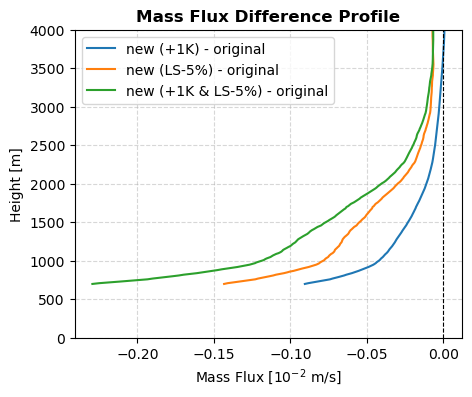

In [45]:
plt.figure(figsize=(5, 4))

plt.plot((MdK_out[iae]-M_out[iae])*1e2, z, label='new (+1K) - original')
plt.plot((M5_out[iae]-M_out[iae])*1e2, z, label='new (LS-5%) - original')
plt.plot((MdK5_out[iae]-M_out[iae])*1e2, z, label='new (+1K & LS-5%) - original')

plt.axvline(0, color='k', linestyle='--', linewidth=0.8)

# plt.xlim(0, 20)
plt.ylim(0, 4000)

plt.xlabel(f"Mass Flux [$10^{{-2}}$ m/s]")
plt.ylabel("Height [m]")
plt.title("Mass Flux Difference Profile", fontweight='bold')

plt.grid(linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [43]:
print(M_out[iae][izcb], MdK_out[iae][izcb], M5_out[iae][izcb], MdK5_out[iae][izcb])
print(f"{(MdK_out[iae][izcb]-M_out[iae][izcb])/M_out[iae][izcb]:.2%}")
print(f"{(M5_out[iae][izcb]-M_out[iae][izcb])/M_out[iae][izcb]:.2%}")
print(f"{(MdK5_out[iae][izcb]-M_out[iae][izcb])/M_out[iae][izcb]:.2%}")

0.028664788 0.027759071 0.02723154 0.026371123
-3.16%
-5.00%
-8.00%


### Distributions

In [47]:
# Total sinking rate (entrainment + autoconversion): ec + ac [1/km]
# 0.649884 is the minimum value that gives cloud-top below 4000 m (highest cloud-top height)
aeod = 1e-3 * np.arange(0.5, 6.05, 0.05)
ecd = (1 - x) * aeod # entrainment coefficient
acd = x * aeod       # autoconversion coefficient

In [49]:
# Run model for multiple combinations of α+ϵ
qtd0_out = []
qld0_out = []
Fcldd0_out = []
Fprd0_out = []
Md0_out = []
zd0_out = []
qtd1_out = []
qld1_out = []
Fcldd1_out = []
Fprd1_out = []
Md1_out = []
zd1_out = []
for ae in aeod:
    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
    ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    # print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    Fcld = cloudflux_downward(ae, dz, x, ql, qm, qt, Ft, izcb, izct)
    Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    M = Fcld / (qt - qm)

    # Output results
    qtd0_out.append(qt)
    qld0_out.append(ql)
    Fcldd0_out.append(Fcld)
    Fprd0_out.append(Fpr)
    Md0_out.append(M)
    zd0_out.append(z[izct])

    # === Fixed precipitation efficiency x ===
    # Calculate total water content
    qt = q_total(ae, dz, x, qsdK, qmdK, qdK_zcb, izcb)
    ql = np.maximum(qt - qsdK, 0.0)           # cloud liquid water content

    # Find the cloud-top height where ql goes to zero above the cloud base
    izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb
    # print(f"Case with α+ϵ= {ae*1e+3:.6f} 1/km, cloud top at {z[izct]:.2f} m")

    # Calculate cloud moisture flux (integrating downward from cloud top)
    Fcld = cloudflux_downward(ae, dz, x, ql, qmdK, qt, FtdK5, izcb, izct)
    Fpr = Fcld - FtdK5 # Precipitation flux must be zero above cloud top

    # Calculate mass flux
    M = Fcld / (qt - qmdK)

    # Output results
    qtd1_out.append(qt)
    qld1_out.append(ql)
    Fcldd1_out.append(Fcld)
    Fprd1_out.append(Fpr)
    Md1_out.append(M)
    zd1_out.append(z[izct])

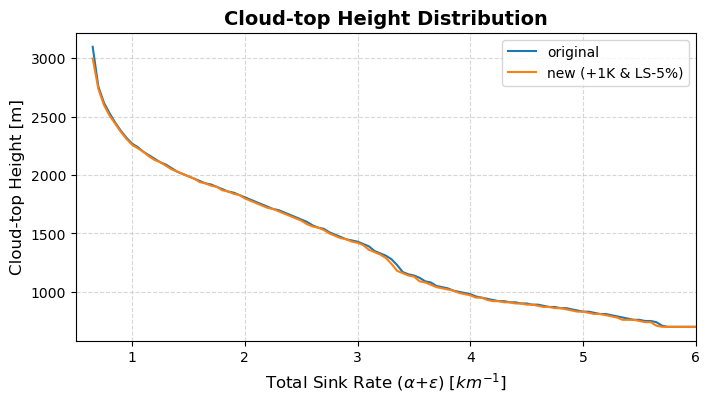

In [ ]:
plt.figure(figsize=(8, 4))

# plt.subplot(2, 1, 1)
plt.plot(aeod[3:]*1e+3, zd0_out[3:], label='original')
plt.plot(aeod[3:]*1e+3, zd1_out[3:], linestyle='-', label='new (+1K & LS-5%)')

plt.xlim(0.5, 6)

plt.xlabel(r"Total Sink Rate ($\alpha$+$\epsilon$) [$km^{{-1}}$]", fontsize=12)
plt.ylabel("Cloud-top Height [m]", fontsize=12)
plt.title("Cloud-top Height Distribution", fontsize=14, fontweight='bold')

plt.legend()
plt.grid(linestyle='--', alpha=0.5)